In [1]:
import numpy as np
import random
from pylab import exp
import scipy.stats as sts
import pandas as pd
from matplotlib import pyplot as plt

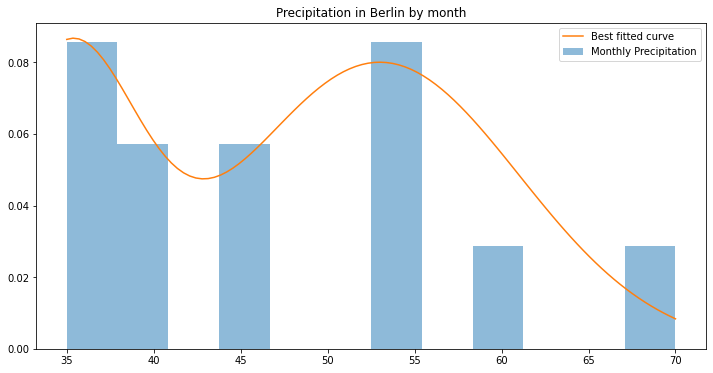

In [2]:
# Data from the online source: https://www.climatestotravel.com/climate/germany/berlin
monthly_rainfall_record = [40, 35, 40, 35, 55, 70, 55, 60, 45, 35, 45, 55]
plt.figure(figsize = (12, 6))
plt.hist(monthly_rainfall_record, bins=12, density=True, alpha=0.5, label='Monthly Precipitation')
plt.title('Precipitation in Berlin by month')

# A bimodal distribution
X = np.linspace(min(monthly_rainfall_record), max(monthly_rainfall_record), 100)
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

plt.plot(X, bimodal(X, 35,4,0.08,53,8,0.08), label='Best fitted curve')
plt.legend()
plt.show()

In [3]:
class FloodSim:

    def __init__(self, topology_map, water_depth, prob_rain, radius=1, evaporation_rate = 0.65):
        '''
        Initialize new MajoritySimulator object with default parameter settings.

        Inputs:

            size (int) The number of cells along each dimension of the
              2-dimensional grid. Default: 100.

            initial_density (float) The proportion of cells that will be
              active (1) when the cellular automaton is initialized. The
              active cells will be at random locations. Default: 0.1.

            radius (int) The radius of the neighborhoods in the CA.
              Must be a positive integer. Default: 1.
        '''
        
        self.radius = radius
        
        # Cell value is given by topology_map + water_depth
        self.topology = topology_map
        self.water_level = water_depth
        self.water_level_next = np.zeros(self.water_level.shape)
        self.current_state = np.zeros(topology_map.shape)
        self.month = 0
        self.step_counter = 0
        # Assumption: evaporation ratio 0.65
        # Est. source: https://journals.ametsoc.org/view/journals/bams/42/3/1520-0477-42_3_185.xml
        self.evaporation_rate = evaporation_rate
        self.prob_rain = prob_rain
        self.waterlog_count = np.zeros(self.current_state.shape)
    
    def initialize(self):
        self.current_state = self.topology + self.water_level
              
    def step(self):
        '''
        Update the state of the cellular automaton.
        '''
        # Assumption 1: prob of precipitation annually is approximately 30% 
        # Estimation source: https://www.climatestotravel.com/climate/germany/berlin
        if np.random.uniform(0, 1) < self.prob_rain[self.month]:
            # Assumption 2: precipitation = monthly rainfall record + random noise
            # uniform unit: m; monthly average
            rainfall = monthly_rainfall_record[self.month]/1000 + np.random.normal(0.1, 0.02)
            # All cell value uniformly increase by the precipitation amount
            #self.current_state += rainfall 
            self.water_level += rainfall
        # No rainfall -> evaporate
        else:
            #self.current_state -= 0.35*self.water_level
            self.water_level *= (1-self.evaporation_rate)
        
        # Copy the values of the current state to the next state
        #self.next_state = self.current_state
        self.water_level_next = self.water_level
        # Iterate over all cells
        for i in range(self.current_state.shape[0]):
            for j in range(self.current_state.shape[1]):
                # Compared with the adjacent neighbors
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        # Not include the central cell
                        if not (dx == 0 and dy == 0):
                            # pre-check: if this cell is waterlogged
                            # Soil water retention is 25%
                            # Source: https://en.wikipedia.org/wiki/Soil_water_(retention)#:~:text=Roughly%20speaking%20for%20agriculture%20(top,properties%20of%20a%20given%20soil.
                            if self.water_level[i, j] > self.topology[i, j]/100*0.25:
                                # Must get rid of the extra water and flow equally into neighbors
                                extra_flow = (self.water_level[i, j] - self.topology[i, j]/100*0.25)/((self.radius*2+1)**2-1)
                                #self.next_state[(i + dx) % self.current_state.shape[0],
                                                #(j + dy) % self.current_state.shape[1]] += extra_flow
                                #self.next_state[i, j] -= extra_flow
                                self.water_level_next[(i + dx) % self.current_state.shape[0],
                                                      (j + dy) % self.current_state.shape[1]] += extra_flow
                                self.water_level_next[i, j] -= extra_flow
                                self.waterlog_count[i, j] += 1
                            
                            # temporarily copy the values back for further comparisons
                            self.water_level = self.water_level_next
                            # if the central cell has a higher cell value, flow into the neighbor
                            if self.current_state[i, j] > self.current_state[(i + dx) % self.current_state.shape[0],
                                                                             (j + dy) % self.current_state.shape[1]]:
                                # A normalized scalar to help determine the flow speed:
                                # if two cells have a larger difference in elevation, the water flow will be larger
                                slope = abs(self.topology[i, j] - self.topology[(i + dx) % self.current_state.shape[0],
                                                                                (j + dy) % self.current_state.shape[1]])/400
                                # In each comparison, we try to eliminate the water level difference
                                flow = slope*(self.water_level[i, j] - self.water_level[(i + dx) % self.current_state.shape[0],
                                                                                        (j + dy) % self.current_state.shape[1]])/2
                                #self.next_state[(i + dx) % self.current_state.shape[0], (j + dy) % self.current_state.shape[1]] += flow
                                #self.next_state[i, j] -= flow
                                self.water_level_next[(i + dx) % self.current_state.shape[0],
                                                      (j + dy) % self.current_state.shape[1]] += flow
                                self.water_level_next[i, j] -= flow
        
        # Update:
        # only positive water depths
        self.water_level_next[self.water_level_next<0] = 0
        self.water_level = self.water_level_next
        self.current_state = self.water_level + self.topology
        self.step_counter += 1
        self.month = (self.month + 1)%12

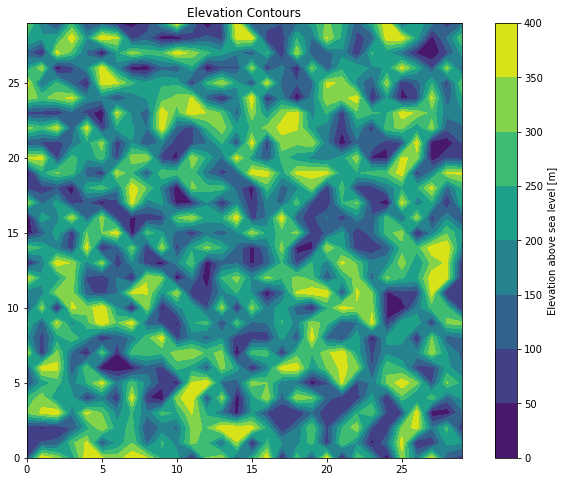

In [4]:
# Set random seed to make the results reproducible
random.seed(10)

# A random topology
# 30*30 matrix
# each cell's value represent its elevation above sea level (m)
initial_topology_map = np.array(np.random.randint(0, 400, size=(30, 30)).astype('float64'))

# A filled contour plot
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(initial_topology_map, cmap = "viridis", 
            levels = list(range(0, 450, 50)))
plt.title("Elevation Contours")
cbar = plt.colorbar(label='Elevation above sea level [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

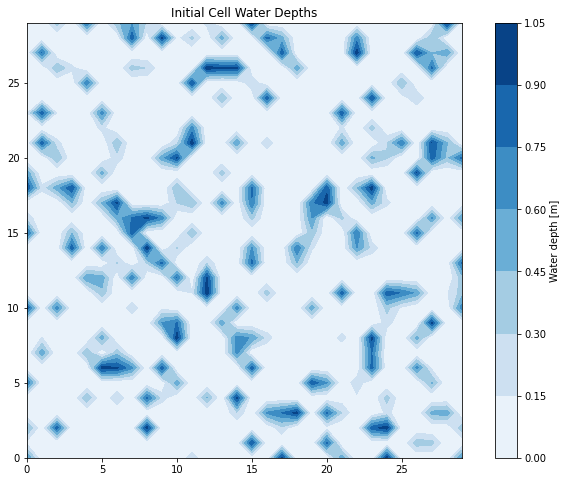

In [5]:
random.seed(10)
initial_water_depth = initial_topology_map.copy()
for i in range(30):
    for j in range(30):
        # Initial water depth: only water in some shallow areas
        if initial_water_depth[i][j] < 100:
            initial_water_depth[i][j] = np.random.uniform(0, 1)
        else:
            initial_water_depth[i][j] = 0

# A filled contour plot
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(initial_water_depth, cmap = 'Blues')
plt.title("Initial Cell Water Depths")
cbar = plt.colorbar(label='Water depth [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

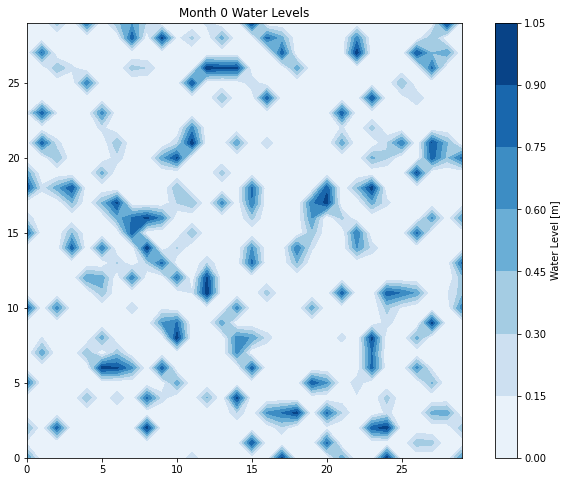

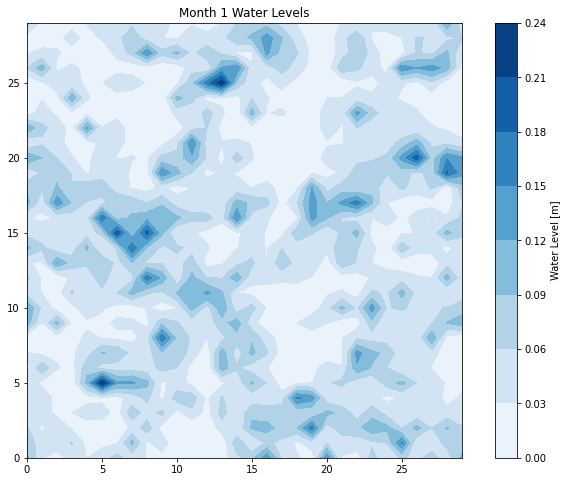

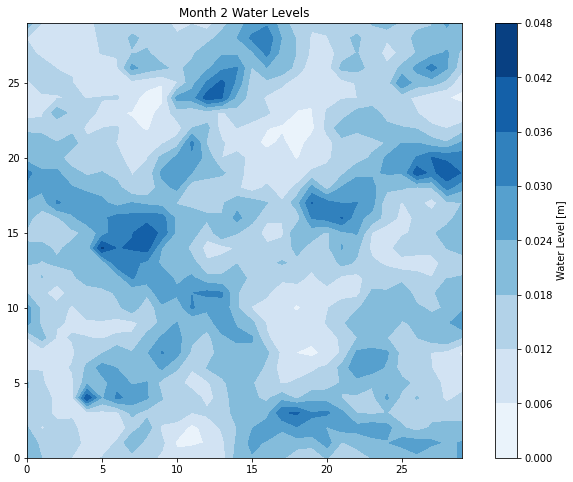

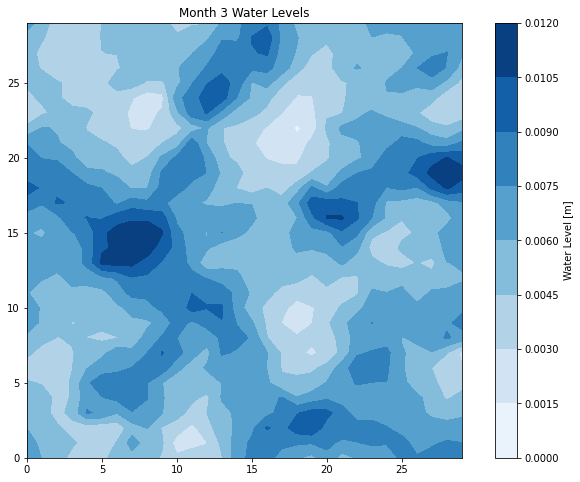

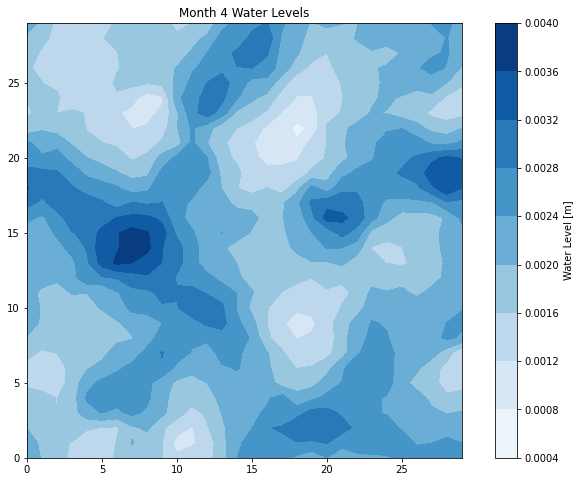

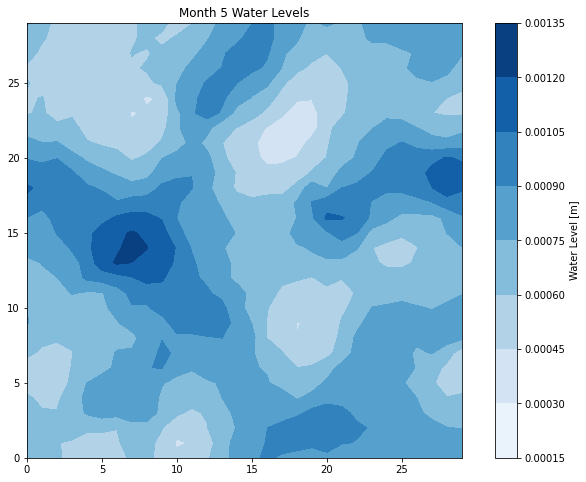

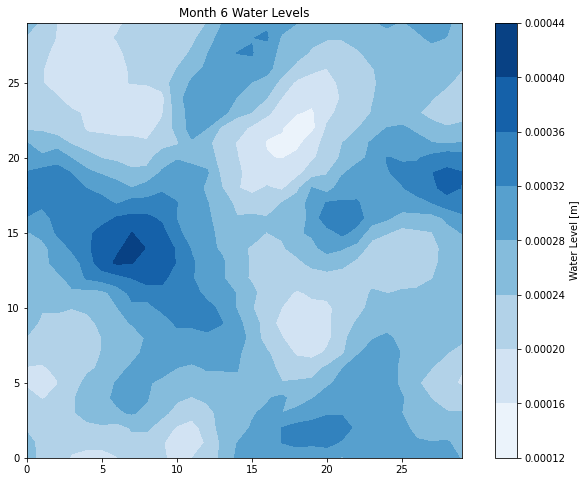

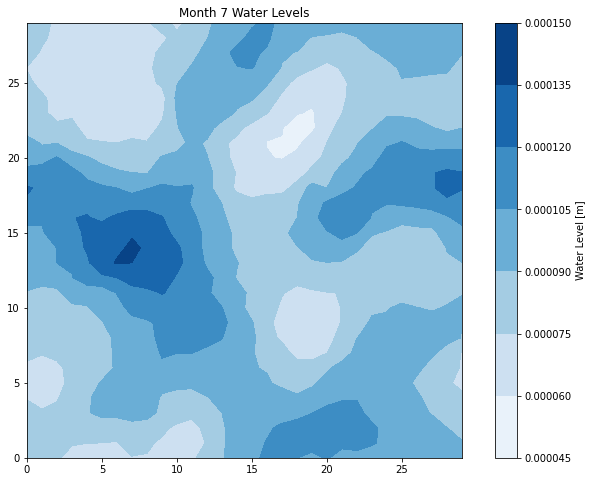

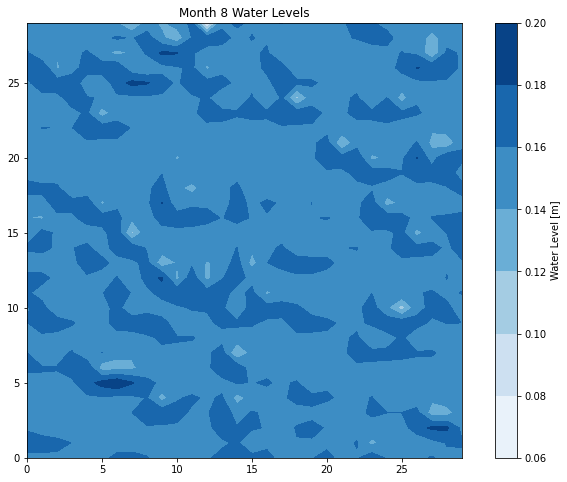

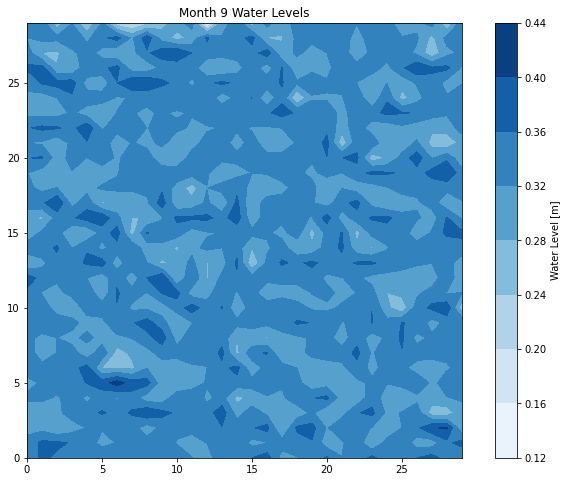

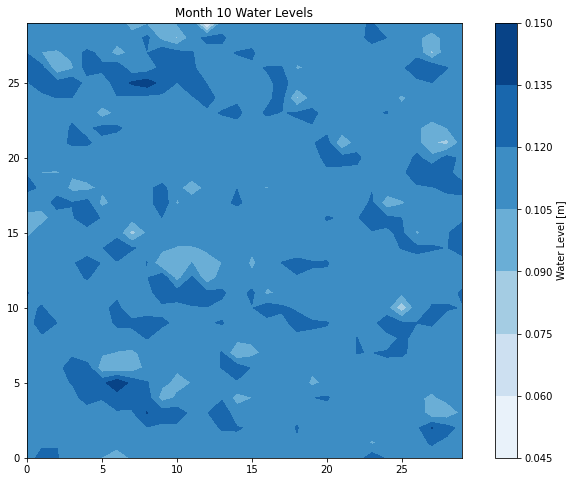

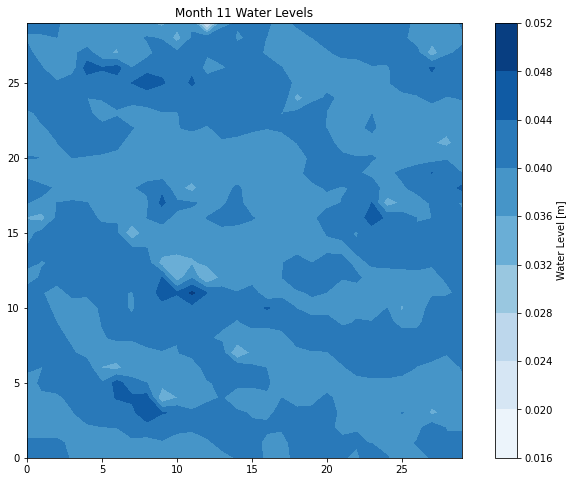

In [6]:
# Set random seed to make the results reproducible
random.seed(10)
prob = [10/31, 8/28, 9/31, 8/30, 9/31, 10/30, 8/31, 8/31, 8/30, 8/31, 10/30, 11/31]
sim = FloodSim(initial_topology_map, initial_water_depth, prob)
sim.initialize()
# The initial water potential
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(sim.water_level, cmap = "Blues")#, levels = np.linspace(0, 1))
plt.title("Month 0 Water Levels")
cbar = plt.colorbar(label='Water Level [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Simulate what happens in Berlin in the next year
n_trials = 11
for _ in range(n_trials):
    #for i in range(24):
    sim.step()
    # A filled contour plot
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    plt.contourf(sim.water_level, cmap = "Blues")#, levels = np.linspace(0, 0.3))
    plt.title(f"Month {sim.month} Water Levels")
    cbar = plt.colorbar(label='Water Level [m]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

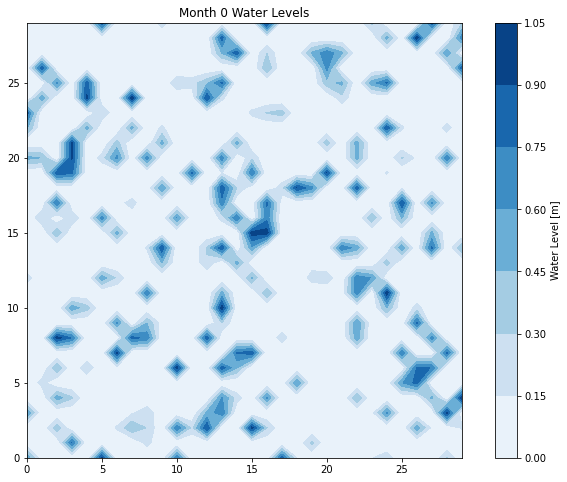

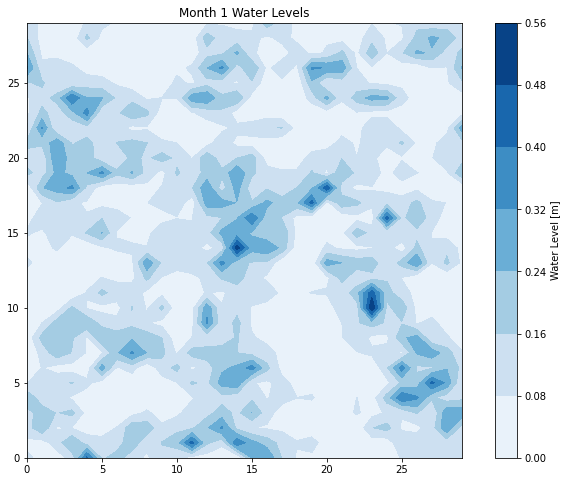

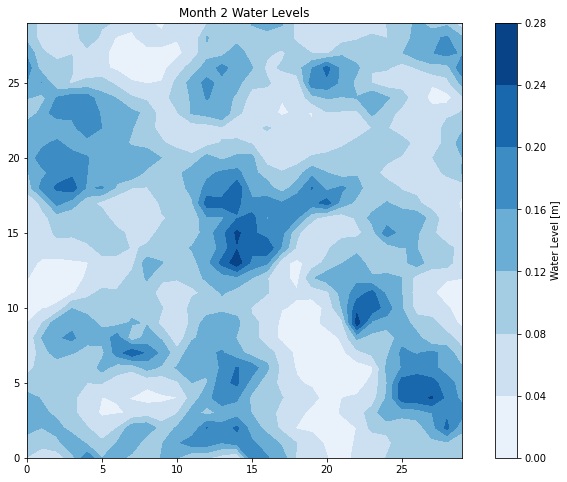

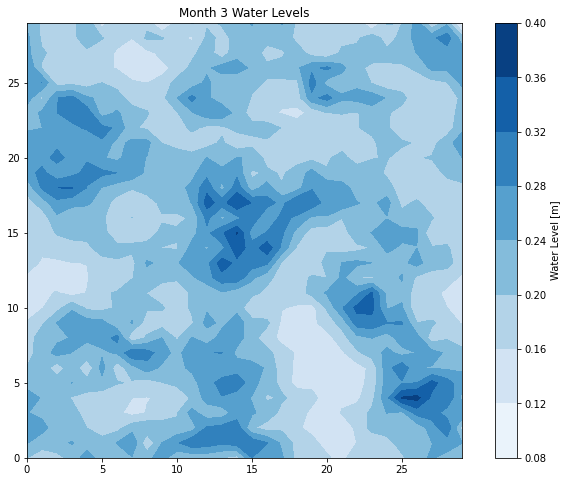

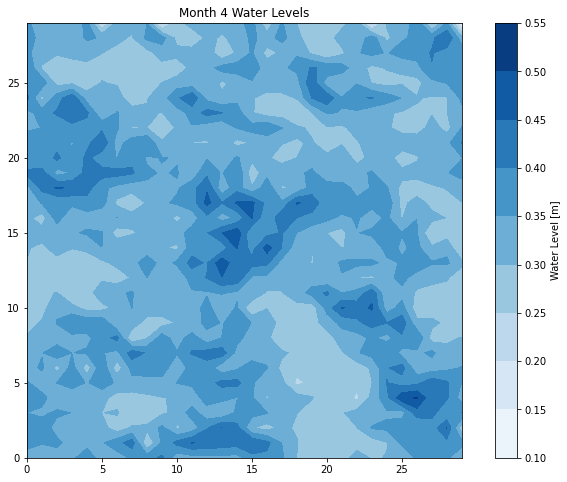

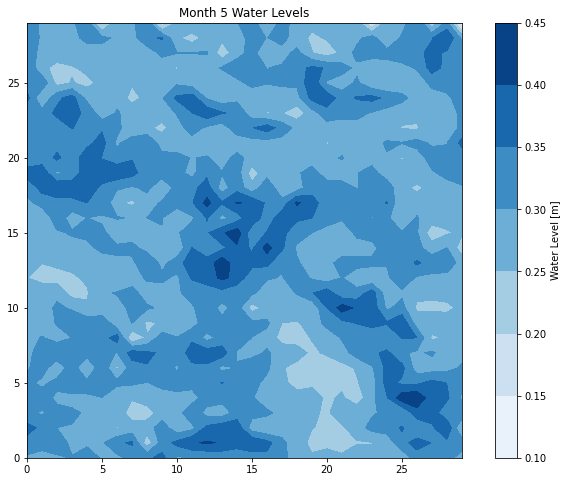

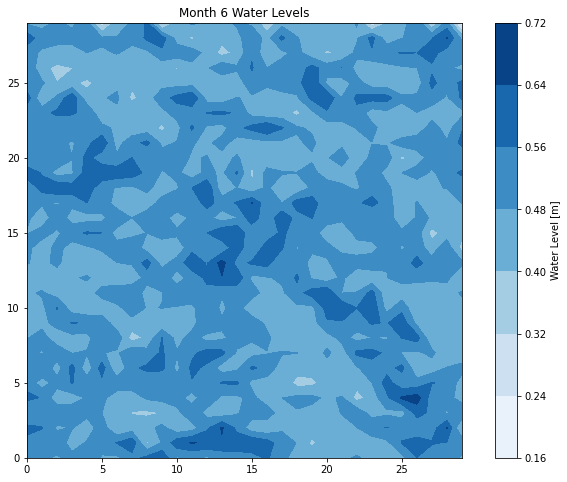

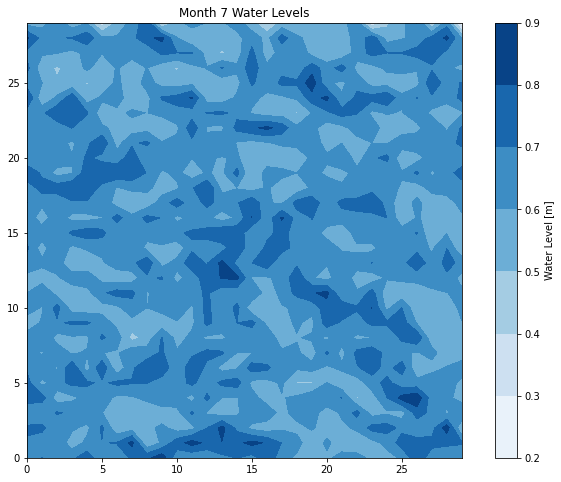

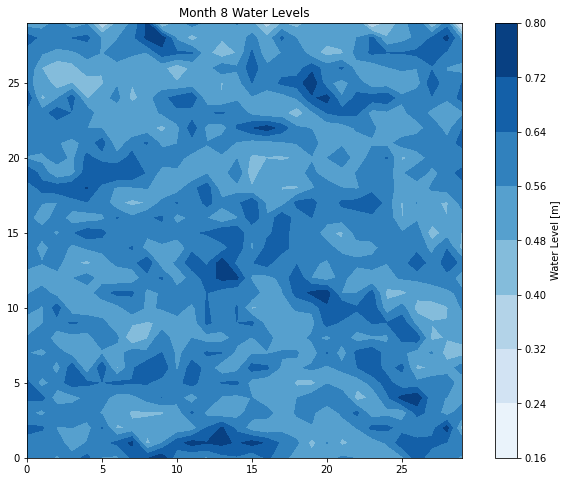

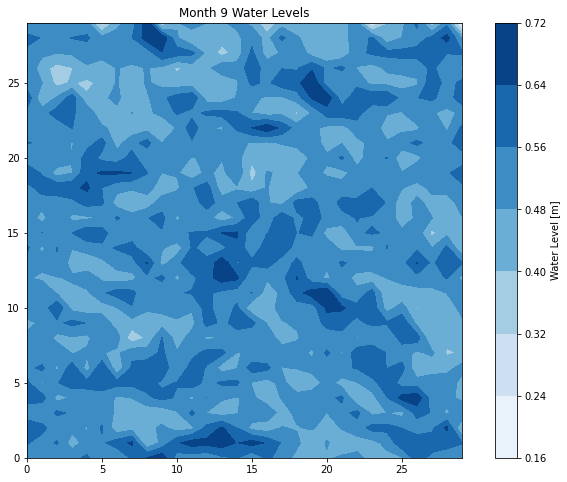

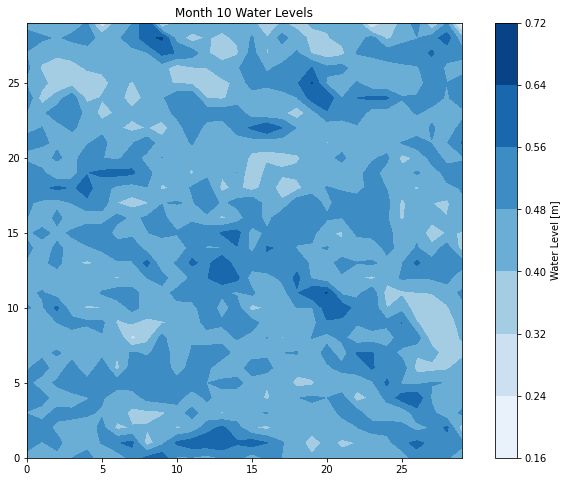

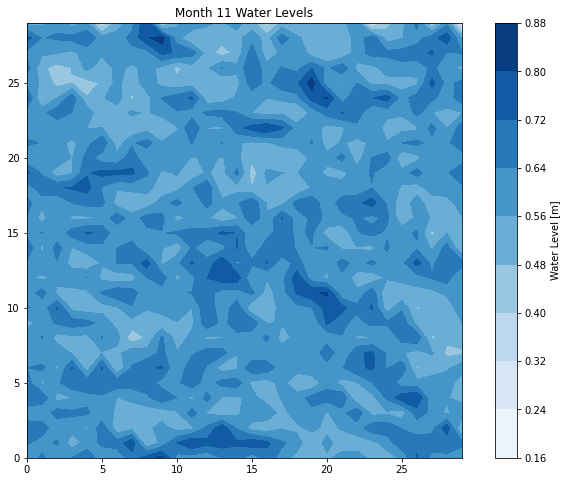

In [7]:
# Set random seed to make the results reproducible
random.seed(10)
initial_topology_map = np.array(np.random.randint(0, 400, size=(30, 30)).astype('float64'))
initial_water_depth = initial_topology_map.copy()
for i in range(30):
    for j in range(30):
        # Initial water depth: only water in some shallow areas
        if initial_water_depth[i][j] < 100:
            initial_water_depth[i][j] = np.random.uniform(0, 1)
        else:
            initial_water_depth[i][j] = 0
            
sim = FloodSim(initial_topology_map, initial_water_depth, prob, evaporation_rate = 0.1)
sim.initialize()
# The initial water potential
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(sim.water_level, cmap = "Blues")#, levels = np.linspace(0, 1))
plt.title("Month 0 Water Levels")
cbar = plt.colorbar(label='Water Level [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Simulate what happens in Berlin in the next year
n_trials = 11
for _ in range(n_trials):
    #for i in range(24):
    sim.step()
    # A filled contour plot
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    plt.contourf(sim.water_level, cmap = "Blues")#, levels = np.linspace(0, 1))
    plt.title(f"Month {sim.month} Water Levels")
    cbar = plt.colorbar(label='Water Level [m]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [8]:
def run_simulation(n_trials, topology_map, water_depth, prob_rain_lst, evap_rate):
    sim = FloodSim(topology_map, initial_water_depth, prob_rain=prob_rain_lst, evaporation_rate=evap_rate, radius=1)  
    sim.initialize()
    # Create empty dictionary to store values
    # Key: month number
    # Value: average state of water level
    results = dict((key+1, []) for key in list(range(12)))
    for i in range(n_trials):
        sim.step()
        results[sim.month+1].append(np.mean(sim.water_level))
    return results

water_levels = run_simulation(10000, initial_topology_map, initial_water_depth, prob, 0.65)

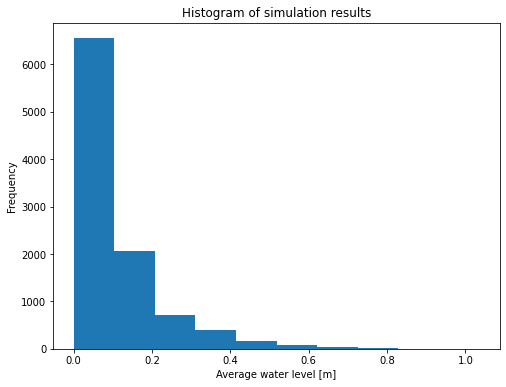

In [10]:
import itertools

plt.figure(figsize=(8, 6))
plt.hist(list(itertools.chain.from_iterable(water_levels.values())))
plt.title('Histogram of simulation results')
plt.xlabel('Average water level [m]')
plt.ylabel('Frequency')
plt.show()

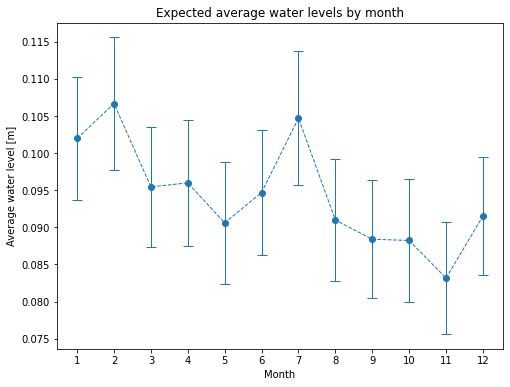

In [11]:
avgList = []
std_err = []
for k, v in water_levels.items():
    # v is the list of average water levels
    avgList.append(np.mean(v))
    std_err.append(sts.sem(v))

avgList = np.array(avgList)
std_err = np.array(std_err)

# Plot the data 
plt.figure(figsize=(8, 6))
plt.title('Expected average water levels by month')
plt.xlabel('Month')
plt.ylabel('Average water level [m]')
x_range = list(i+1 for i in range(12))
error = 1.96*std_err
plt.errorbar(x_range, y=avgList, yerr=error, marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xticks(list(range(1, 13)))
plt.show()

In [12]:
# No need for separating month and water level
def sim_average_water_level(n_trials, topology_map, water_depth, prob_rain_lst, evap_rate):
    sim = FloodSim(topology_map, initial_water_depth, prob_rain=prob_rain_lst, evaporation_rate=evap_rate, radius=1)  
    sim.initialize()
    results = []
    for i in range(n_trials):
        sim.step()
        results.append(np.mean(sim.water_level))
    return results

In [13]:
# Evaporation rate's impact on average water levels in the city
ratio = np.linspace(0.1, 0.9, 20)
sim_results = []
for i in ratio:
    sim_results.append(sim_average_water_level(100, initial_topology_map, initial_water_depth, prob, i))

Exponential Relationship: 1.67*exp(-9.42*x)+0.09


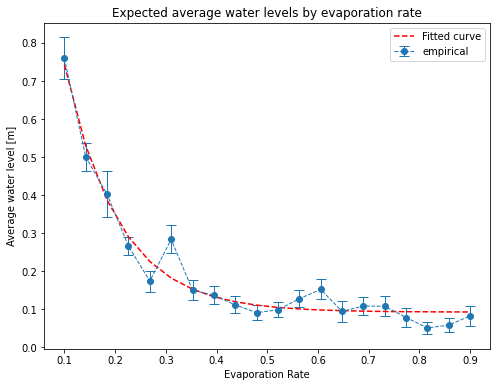

In [15]:
avgList_ratio = []
std_err_ratio = []
for item in sim_results:
    avgList_ratio.append(np.mean(item))
    std_err_ratio.append(sts.sem(item))

avgList_ratio = np.array(avgList_ratio)
std_err_ratio = np.array(std_err_ratio)

# Plot the data 
plt.figure(figsize=(8, 6))
plt.title('Expected average water levels by evaporation rate')
plt.xlabel('Evaporation Rate')
plt.ylabel('Average water level [m]')
error = 1.96*std_err_ratio
plt.errorbar(ratio, y=avgList_ratio, yerr=error, marker='o', capsize=5, linestyle='--', linewidth=1, label='empirical')

from scipy.optimize import curve_fit
# Fit an exponential distribution to the data
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c
popt, pcov = curve_fit(exp_func, ratio, avgList_ratio)
y = [exp_func(i, popt[0], popt[1], popt[2]) for i in ratio]
plt.plot(ratio, y, 'r--', label='Fitted curve')
print(f'Exponential Relationship: {round(popt[0], 2)}*exp({round(-popt[1], 2)}*x)+{round(popt[2], 2)}')
plt.legend()
plt.show()

In [16]:
# The most dangerous places in the city
def flood_danger(n_steps, topology_map, water_depth, prob_rain_lst, evap_rate):
    sim = FloodSim(topology_map, initial_water_depth, prob_rain=prob_rain_lst, evaporation_rate=evap_rate, radius=1)  
    sim.initialize()
    results = np.zeros(topology_map.shape)
    for i in range(n_steps):
        sim.step()
        results += sim.waterlog_count
    return results # a numpy array recording how many times each cell is waterlogged in n_steps

total_count = np.zeros(initial_topology_map.shape)
for i in range(100):
    initial_water_depth = initial_topology_map.copy()
    for i in range(30):
        for j in range(30):
            # Initial water depth: only water in some shallow areas
            if initial_water_depth[i][j] < 100:
                initial_water_depth[i][j] = np.random.uniform(0, 1)
            else:
                initial_water_depth[i][j] = 0
    total_count += flood_danger(10, initial_topology_map, initial_water_depth, prob, 0.65)
total_count = total_count/100 # average amount of times 

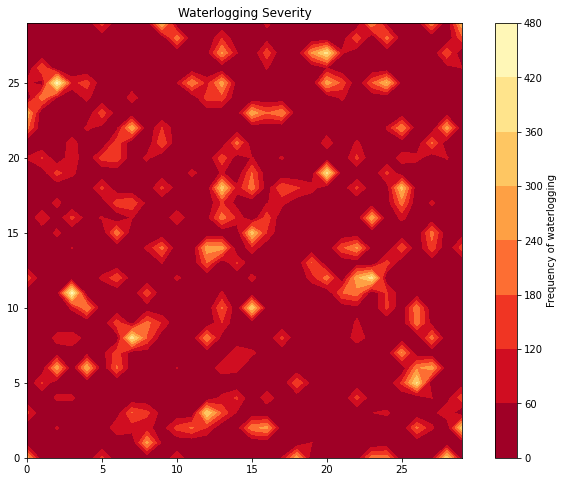

In [17]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(total_count, cmap = plt.cm.YlOrRd_r)
plt.title("Waterlogging Severity")
cbar = plt.colorbar(label='Frequency of waterlogging')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [18]:
# The most dangerous places in the city
def water_level_danger(n_steps, topology_map, water_depth, prob_rain_lst, evap_rate):
    sim = FloodSim(topology_map, initial_water_depth, prob_rain=prob_rain_lst, evaporation_rate=evap_rate, radius=1)  
    sim.initialize()
    results = np.zeros(topology_map.shape)
    for i in range(n_steps):
        sim.step()
        # Average water level among n_steps
        results += sim.water_level/n_steps
    return results # a numpy array recording how many times each cell is waterlogged in n_steps

total_count_flooding = np.zeros(initial_topology_map.shape)
n_trials = 100
for i in range(n_trials):
    initial_water_depth = initial_topology_map.copy()
    for i in range(30):
        for j in range(30):
            # Initial water depth: only water in some shallow areas
            if initial_water_depth[i][j] < 100:
                initial_water_depth[i][j] = np.random.uniform(0, 1)
            else:
                initial_water_depth[i][j] = 0
    total_count_flooding += water_level_danger(10, initial_topology_map, initial_water_depth, prob, 0.65)
total_count_flooding = total_count/n_trials # average amount of times 

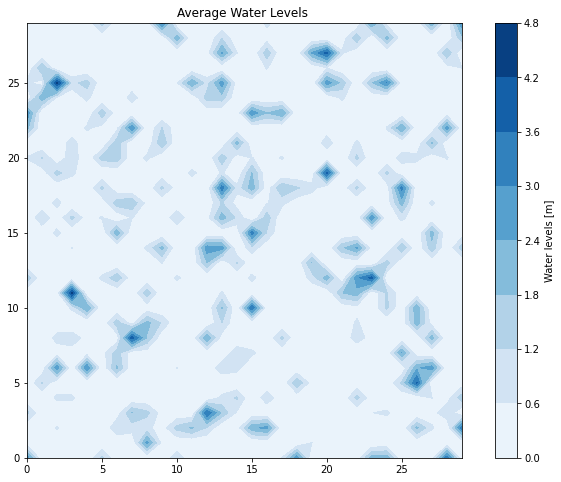

In [19]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(total_count_flooding, cmap = "Blues")
plt.title("Average Water Levels ")
cbar = plt.colorbar(label='Water levels [m]')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()